# Exploratory Data Analysis (EDA)

In this notebook, we analyze the relationship between socioeconomic factors and Olympic success.
We use the processed dataset which includes:
- **GDP per Capita:** Economic Wealth
- **Active Population (15-64):** The potential pool of athletes
- **Total Medals:** Sports Success

**Hypotheses to Test:**
1. **H1:** Wealthier countries win more medals.
2. **H2:** Countries with larger populations win more medals.

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Load Data
df = pd.read_csv('../data/processed/processed_sports_gdp_population.csv')

# --- COLUMN NAME STANDARDIZATION ---
# Fix 'Total' -> 'Total_Medals'
if 'Total' in df.columns:
    df.rename(columns={'Total': 'Total_Medals'}, inplace=True)

# Fix Country Name Issues (The Root Cause of KeyError)
# Pandas might have renamed 'Country' to 'Country_x' or kept 'Country_Mapped'
if 'Country_x' in df.columns:
    df.rename(columns={'Country_x': 'Country'}, inplace=True)
elif 'Country_Mapped' in df.columns:
    df.rename(columns={'Country_Mapped': 'Country'}, inplace=True)

# Drop redundant columns if they exist (Clean up)
if 'Country_y' in df.columns:
    df.drop(columns=['Country_y'], inplace=True)

print("✅ Data Loaded and Columns Fixed.")
print(f"Final Columns: {df.columns.tolist()}")
display(df.head())

✅ Data Loaded and Columns Fixed.
Final Columns: ['Year', 'Rank', 'NOC', 'Gold', 'Silver', 'Bronze', 'Total_Medals', 'Country', 'Country_Mapped', 'GDP_Per_Capita', 'Total_Population', 'Active_Population_Total']


,Year,Rank,NOC,Gold,Silver,Bronze,Total_Medals,Country,Country_Mapped,GDP_Per_Capita,Total_Population,Active_Population_Total
0,1992,22,Norway,2,4,1,7,Norway,Norway,34875.0,4359184.0,2815261.0
1,1992,28,New Zealand,1,4,5,10,New Zealand,New Zealand,17189.0,3673400.0,2403555.0
2,1992,25,Brazil,2,1,0,3,Brazil,Brazil,4781.0,161735073.0,101167654.0
3,1992,27,Sweden,1,7,4,12,Sweden,Sweden,30520.0,8826939.0,5621611.0
4,1992,19,Poland,3,6,10,19,Poland,Poland,3705.0,38594998.0,25490654.0


## 1. Correlation Analysis
Before visualizing, let's look at the "Big Picture".
We will calculate the correlation matrix to see how strongly these variables are related mathematically.

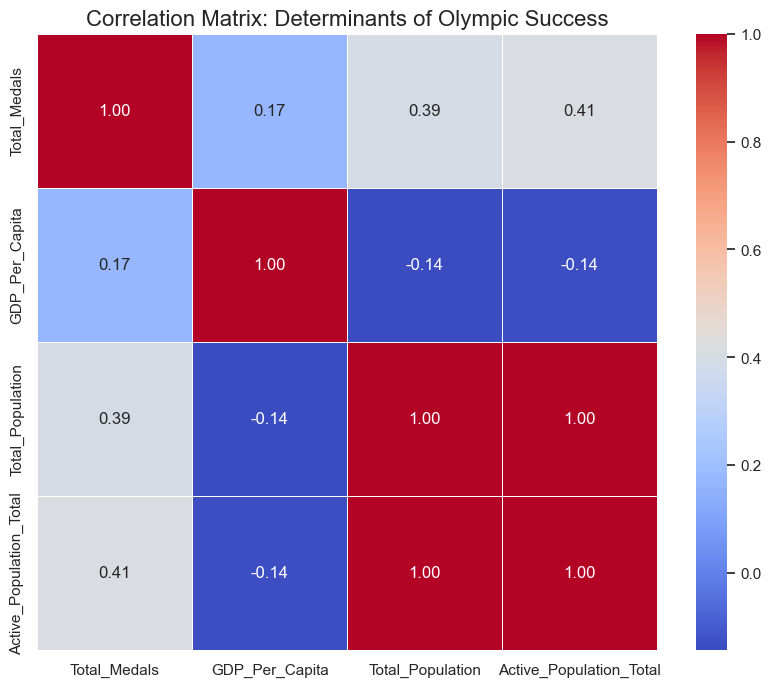

In [22]:
# Select columns for correlation analysis
# We compare Success (Total_Medals) with Wealth (GDP) and Population
cols_to_analyze = ['Total_Medals', 'GDP_Per_Capita', 'Total_Population', 'Active_Population_Total']

# Calculate Correlation Matrix
correlation_matrix = df[cols_to_analyze].corr()

# Visualize with a Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True,       # Show numbers
    cmap='coolwarm',  # Color scheme (Red=High, Blue=Low)
    fmt=".2f",        # 2 decimal places
    linewidths=0.5
)
plt.title('Correlation Matrix: Determinants of Olympic Success', fontsize=16)
plt.show()

## 2. Hypothesis 1: Wealth vs. Success
Does money buy medals? Let's visualize the relationship between **GDP per Capita** and **Total Medals**.

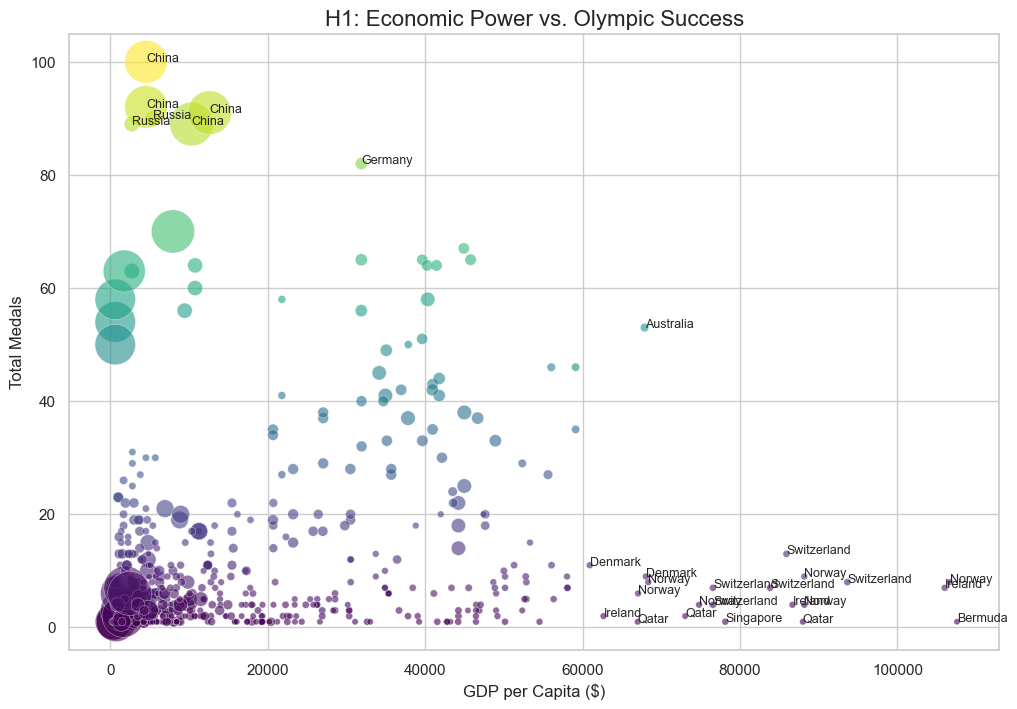

In [28]:
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# --- 1. Sütun Adı Düzeltme (Country Hatası İçin) ---
# Eğer merge işleminden sonra Country_x oluştuysa, onu tekrar Country yapalım
if 'Country_x' in df.columns:
    df.rename(columns={'Country_x': 'Country'}, inplace=True)

# --- 2. Grafik Çizimi ---
sns.scatterplot(
    data=df, 
    x='GDP_Per_Capita', 
    y='Total_Medals', 
    size='Total_Population', # Baloncuk boyutu nüfusu göstersin
    sizes=(20, 1000),
    alpha=0.6,
    hue='Total_Medals',
    palette='viridis',
    legend=False
)

plt.title('H1: Economic Power vs. Olympic Success', fontsize=16)
plt.xlabel('GDP per Capita ($)', fontsize=12)
plt.ylabel('Total Medals', fontsize=12)

# --- 3. Etiketleme (Daha Güvenli Yöntem) ---
# df.iterrows() kullanarak satır satır geziyoruz, hata riskini sıfırlıyoruz.
for index, row in df.iterrows():
    # Kriter: Madalya sayısı 80'den büyükse VEYA Gelir 60.000$'den fazlaysa
    if row['Total_Medals'] > 80 or row['GDP_Per_Capita'] > 60000:
        plt.text(
            x=row['GDP_Per_Capita'], 
            y=row['Total_Medals'], 
            s=row['Country'], # Artık hata vermez
            fontsize=9
        )

plt.savefig('../images/eda_gdp_vs_medals.png')
plt.show()

## 3. Hypothesis 2: Population vs. Success
Does having more people mean more medals? Let's check **Active Population** vs **Total Medals**.

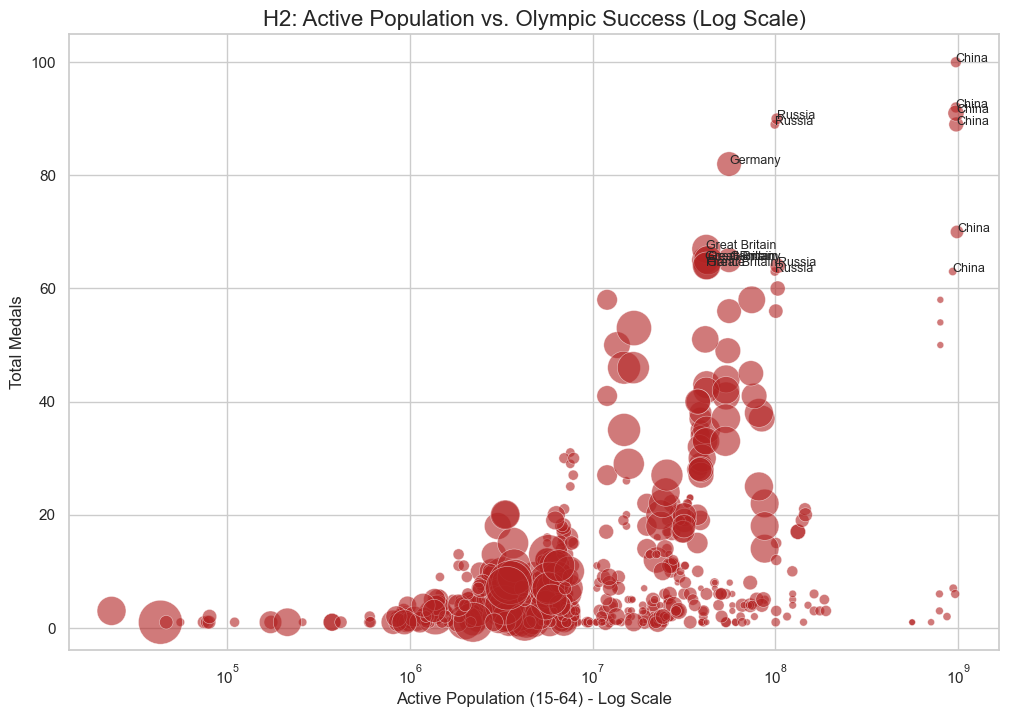

In [32]:
plt.figure(figsize=(12, 8))

# We use log scale for Population because China/India are too big compared to others
sns.scatterplot(
    data=df, 
    x='Active_Population_Total', 
    y='Total_Medals', 
    size='GDP_Per_Capita', # This time bubble size is Wealth!
    sizes=(20, 1000),
    alpha=0.6,
    color='firebrick',
    legend=False
)

plt.xscale('log') # Logarithmic scale for x-axis
plt.title('H2: Active Population vs. Olympic Success (Log Scale)', fontsize=16)
plt.xlabel('Active Population (15-64) - Log Scale', fontsize=12)
plt.ylabel('Total Medals', fontsize=12)

# Label top countries
for i in range(len(df)):
    if df.Total_Medals[i] > 60:
        plt.text(df.Active_Population_Total[i], df.Total_Medals[i], df.Country[i], fontsize=9)

plt.savefig('../images/eda_population_vs_medals.png')
plt.show()

## 4. Understanding the Low Correlation (Outlier Analysis)
Our correlation analysis showed a weak relationship (approx. 0.17) between GDP and Medals.
To understand **why**, we need to look at the exceptions (outliers):
1. **Small Giants:** Countries with small populations/economies that perform exceptionally well.
2. **Rich Underperformers:** Wealthy countries that do not win many medals.

These outliers disrupt the linear relationship.

In [ ]:
# --- 1. THE SMALL GIANTS (Low Pop, High Success) ---
# Criteria: Active Population < 5 Million AND Total Medals > 10
# These are the countries that defy the population logic.

small_giants = df[
    (df['Active_Population_Total'] < 5000000) & 
    (df['Total_Medals'] > 10)
].sort_values('Total_Medals', ascending=False)

print(f"🌍 Small Giants Analysis:")
display(small_giants[['Year', 'Country', 'Total_Medals', 'Active_Population_Total', 'GDP_Per_Capita']].head(10))

🌍 Small Giants Analysis:


,Year,Country,Total_Medals,Active_Population_Total,GDP_Per_Capita
547,2024,New Zealand,20,3321682.0,47412.0
526,2020,New Zealand,20,3326968.0,41967.0
407,2016,New Zealand,18,3022211.0,38789.0
414,2016,Denmark,15,3659047.0,53308.0
374,2012,New Zealand,13,2878163.0,33711.0
380,2012,Jamaica,13,1843404.0,4836.0
245,2008,Jamaica,11,1843404.0,4836.0
404,2016,Jamaica,11,1967143.0,5081.0
530,2020,Denmark,11,3714181.0,60897.0


In [ ]:
# --- 2. THE RICH UNDERPERFORMERS (High Wealth, Low Success) ---
# Criteria: GDP per Capita > $50,000 AND Total Medals < 5
# These explain why the GDP correlation is low (0.17).

rich_underperformers = df[
    (df['GDP_Per_Capita'] > 50000) & 
    (df['Total_Medals'] < 5)
].sort_values('GDP_Per_Capita', ascending=False)

print(f"💸 Rich Underperformers Analysis:")
display(rich_underperformers[['Year', 'Country', 'GDP_Per_Capita', 'Total_Medals']].head(10))

💸 Rich Underperformers Analysis:


,Year,Country,GDP_Per_Capita,Total_Medals
483,2020,Bermuda,107560.0,1
353,2012,Norway,88154.0,4
545,2024,Qatar,87974.0,1
515,2020,Ireland,86656.0,4
573,2024,Singapore,78115.0,1
354,2012,Switzerland,76556.0,4
454,2016,Norway,74785.0,4
320,2012,Qatar,73021.0,2
453,2016,Qatar,66985.0,1
445,2016,Ireland,62636.0,2


### Conclusion on Anomalies
The low correlation (0.17) is largely explained by:
1. **Specialized Sports Cultures:** Countries like **Jamaica, New Zealand, or Cuba** perform incredibly well despite smaller economies/populations due to strong national sports traditions (e.g., Sprinting, Rugby, Boxing).
2. **Wealth is not enough:** High GDP countries like **Luxembourg, Qatar, or Singapore** show that financial resources alone do not guarantee Olympic success without a large population pool or sports infrastructure.